<a href="https://colab.research.google.com/github/peterjsadowski/keras_tutorial/blob/master/2_keras_mnist_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Keras Tutorial
This tutorial introduces:

1) Using the GPU

2) Data generators in Keras.

3) Functional API for complex models.
 


In [2]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import os, sys, socket

import tensorflow as tf
try:
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
except:
    print('No GPU found.')

import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Input, Conv2D, Flatten
import keras.layers.merge as merge
from keras.layers.merge import Concatenate
from keras.utils import np_utils
from keras.optimizers import SGD, Adam

No GPU found.


Using TensorFlow backend.


## Define data generators for training and validation.

In [0]:
# The following function is used to serve up both train and validation data.
def data_generator(X, Y, batchsize):
    nb_classes = 10
    N = X.shape[0]
    while True:
        indices1 = np.random.randint(low=0, high=N, size=(batchsize,))
        indices2 = np.random.randint(low=0, high=N, size=(batchsize,))
        
        X1 = X[indices1,...].astype('float32') / 255.0
        X2 = X[indices2,...].astype('float32') / 255.0
        Y1 = Y[indices1]
        Y2 = Y[indices2]
        T  = (Y1 + Y2) # Sum of values.
        
        X1 = np.expand_dims(X1, axis=1) # For conv with theano, shape=(batchsize, channels, row, col).
        X2 = np.expand_dims(X2, axis=1) # We are just adding a dummy dimension saying that there is one channel.
        
        Y1 = np_utils.to_categorical(Y1, nb_classes)
        Y2 = np_utils.to_categorical(Y2, nb_classes)
        T  = np_utils.to_categorical(T, 19) # 19 possible values.
        
        yield {'input1':X1 , 'input2':X2},  {'out':T, 'aux1':Y1, 'aux2':Y2}
        
# Load data.
(X_train, Y_train), (X_valid, Y_valid) = mnist.load_data() # Shape = (N,28,28), (N,)
# Create generators.
batchsize  = 200 
data_train = data_generator(X_train, Y_train, batchsize)
data_valid = data_generator(X_valid, Y_valid, batchsize)

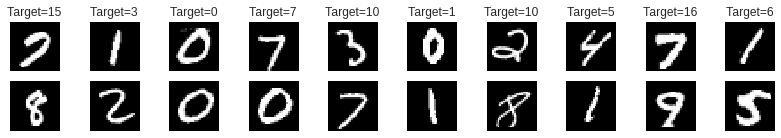

In [4]:
# Plot examples of the data.
inputs, outputs = data_train.__next__()
Xbatch = inputs['input1']
plt.figure(1, figsize=(14,2))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(inputs['input1'][i].reshape(28,28), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.title('Target=%d' % np.argmax(outputs['out'][i]))
    plt.subplot(2,10,10+i+1)
    plt.imshow(inputs['input2'][i].reshape(28,28), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])

# Define Keras Model with the Functional API


In [5]:
# Input data.
input1   = Input(shape=(1, 28,28), dtype='float32', name='input1') # Argument 'name' must match name in dictionary.
input2   = Input(shape=(1, 28,28), dtype='float32', name='input2')

# Layer one: Single convolutional layer applied to each input independently, with "shared weights."
nb_filter      = 32     # Number of convolutional kernels.
nb_row, nb_col = 7,7   # Convolution kernel size.
strides        = (3,3) # Step size for convolution kernels.
conv  =  Conv2D(nb_filter, (nb_row, nb_col), activation='relu', padding='same', strides=strides)
x1    = conv(input1) # Layer object conv transforms data.
x2    = conv(input2)

# Flatten data: transform from (28,28) to (784,)
x1 = Flatten()(x1)
x2 = Flatten()(x2)

# Layer two: Single fully-connected layer applied to each input independently, with shared weights.
layer = Dense(256, activation='relu')
x1 = layer(x1)
x2 = layer(x2)

# Auxiliary softmax layers try to classify digits. 
# The output of these layers aren't fed into the next layer.
#layer = Dense(10) # These weights are shared.
#aux1  = Activation(activation='softmax', name='aux1')(layer(x1)) # Output layers must be named.
#aux2  = Activation(activation='softmax', name='aux2')(layer(x2))

# Merge hidden representations.
#x = merge.Concatenate()([x1, x2])
x = Concatenate()([x1, x2])

# More dense layers then output.
x   = Dense(512, activation='relu')(x)
out = Dense(19, activation='softmax', name='out')(x) # Output layers must be named.

# Create model object that puts it all together.
#model = Model(inputs=[input1, input2], outputs=[out, aux1, aux2])
model = Model(inputs=[input1, input2], outputs=[out])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 1, 28, 28)    0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 1, 28, 28)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1, 10, 32)    43936       input1[0][0]                     
                                                                 input2[0][0]                     
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None

# Optimization

In [0]:
optimizer = Adam(lr=0.001, beta_1=0.99, beta_2=0.999, epsilon=1e-08) # Optimization hyperparameters.

model.compile(optimizer=optimizer,
              loss={'out':'categorical_crossentropy'},
              loss_weights={'out': 1.0}, # 
              metrics=['accuracy'])


## Train the model.

In [9]:
# Callbacks can be used to stop early, decrease learning rate, checkpoint the model, etc.
#from keras.callbacks import EarlyStopping
#stopping  = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')
callbacks = []#[stopping]

# The fit_generator function loads data batches on the fly, instead of transfering entire data set to the gpu.
history   = model.fit_generator(generator=data_train, steps_per_epoch=100, # 500
                                epochs=10, verbose=1,
                                callbacks=callbacks, 
                                validation_data=data_valid, validation_steps=100)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
100/100 [==============================] - 7s 74ms/step - loss: 2.5282 - acc: 0.1630 - val_loss: 2.1615 - val_acc: 0.2457
Epoch 2/10
100/100 [==============================] - 8s 75ms/step - loss: 1.8280 - acc: 0.3599 - val_loss: 1.4547 - val_acc: 0.5298
Epoch 3/10
100/100 [==============================] - 7s 75ms/step - loss: 1.1171 - acc: 0.6488 - val_loss: 0.8004 - val_acc: 0.7674
Epoch 4/10
100/100 [==============================] - 8s 77ms/step - loss: 0.6590 - acc: 0.8048 - val_loss: 0.5271 - val_acc: 0.8530
Epoch 5/10
100/100 [==============================] - 8s 79ms/step - loss: 0.4533 - acc: 0.8708 - val_loss: 0.3860 - val_acc: 0.8888
Epoch 6/10
100/100 [==============================] - 8s 77ms/step - loss: 0.3450 - acc: 0.9023 - val_loss: 0.3087 - val_acc: 0.9102
Epoch 7/10
100/100 [==============================] - 8s 75ms/step - loss: 0.2938 - acc: 0.9156 - val_loss: 0.2604 - val_acc: 0.9231
Epoch 8/10
100/100 [=

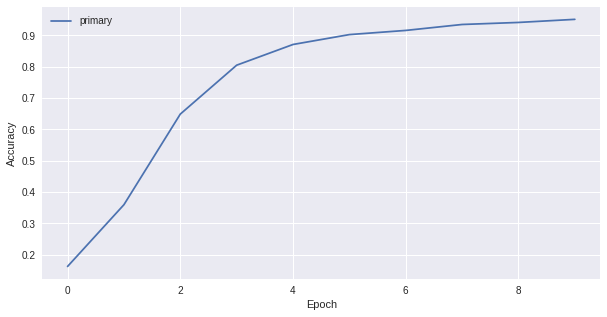

In [11]:
# Plot loss trajectory throughout training.
plt.figure(1, figsize=(10,5))
plt.plot(history.history['acc'], label='primary')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Post-training analysis.

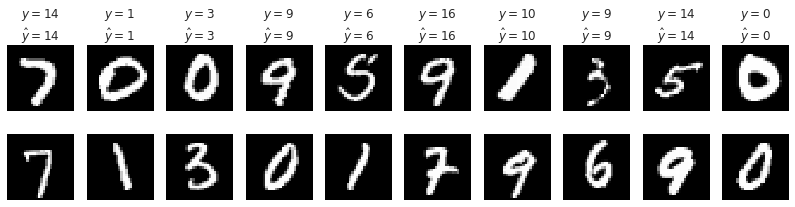

In [14]:
# Plot example pairs for which the network made a mistake.
inputs, outputs = data_valid.__next__()
plt.figure(1, figsize=(14,3))
i = 0
while i < 10:
    inputs, outputs = data_valid.__next__()
    predictions = model.predict(inputs)
    j = 0
    while j < 100:
        yhat   = predictions[j].argmax(axis=-1) # predictions is list: [out, aux1, aux2]
        y      = np.argmax(outputs['out'][j])
        input1 = inputs['input1'][j].reshape(28,28)
        input2 = inputs['input2'][j].reshape(28,28)
        j += 1
        if yhat != y:
            # Prediction was correct. Ignore this example.
            continue
        else:
            # Prediction was incorrect. Show example.
            plt.subplot(2,10,i+1)
            plt.imshow(input1, cmap='gray', interpolation='nearest')
            plt.xticks([])
            plt.yticks([])
            plt.title('Pred=%d' % yhat)
            plt.title('$y=%d$\n$\hat{y}=%d$' % (y,yhat))
            plt.subplot(2,10,10+i+1)
            plt.imshow(input2, cmap='gray', interpolation='nearest')
            plt.xticks([])
            plt.yticks([])
            i += 1
        if not i<10:
            break
        